# 02 - Missings (continuação), HoldOut, Métodos ingênuos e Alisamento 
Nessa aula iremos revisar o conteúdo da última aula, apronfudar na estimação de missings e iniciar os métodos mais simples de previsão.

Irei usar alguns exemplos retirados do livro [Time Series Analysis with Python - Cookbook](https://github.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/tree/main).


In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

def read_dataset(folder, file, date_col=None):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a date_col to use as index_col 
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns) +1
    
    fig, ax = plt.subplots(nrows = subplots_size, ncols = 1, figsize=(12, subplots_size * 6.6), sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0])
    ax[0].set_title('Tabela sem missings')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()

def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

 ## Dados faltantes - Imputação Univariada

In [2]:
folder = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados')

co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_24386/2535030700.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,
/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_24386/2535030700.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,


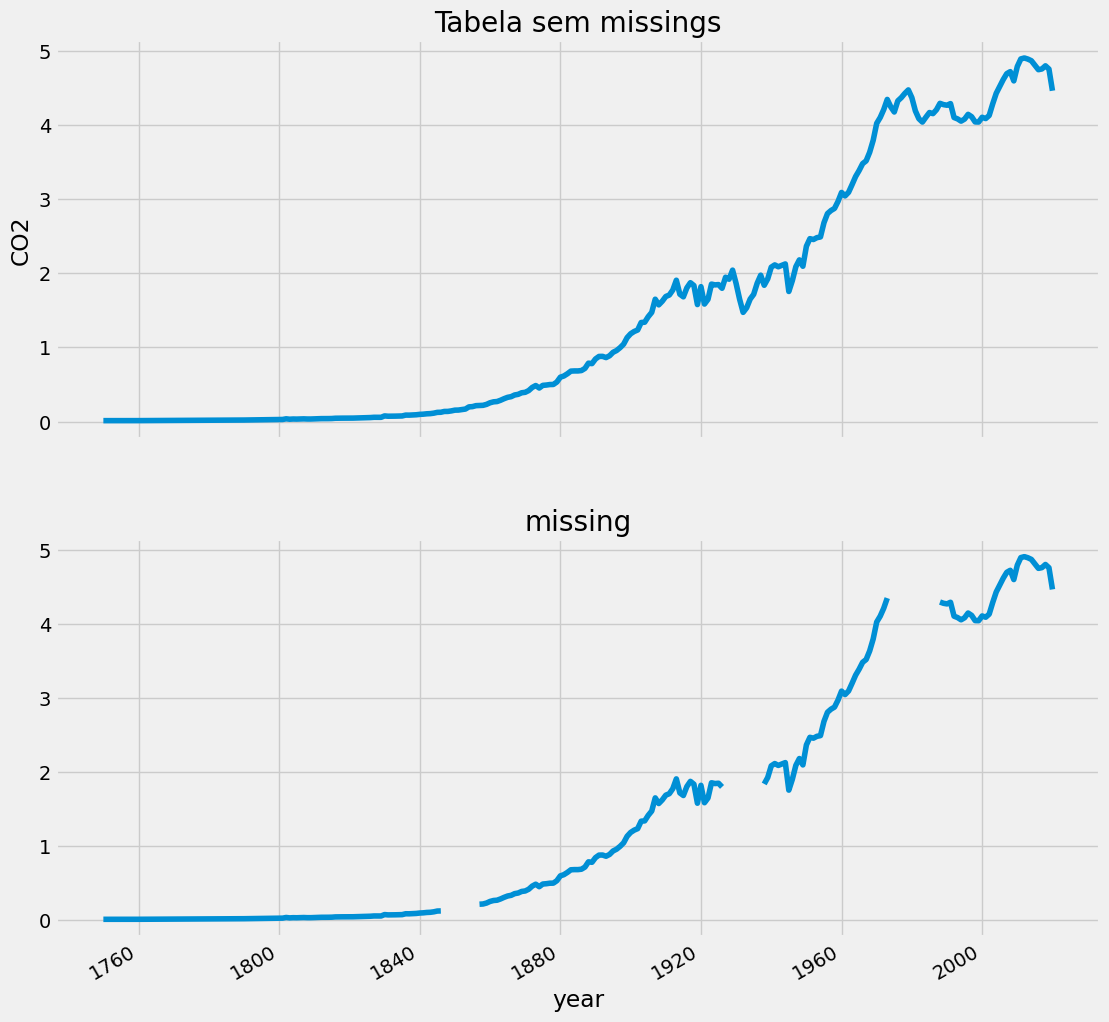

In [3]:
plot_dfs(co2_original, 
         co2_missing, 
         'co2',
         title="Emissões de  CO2 per Capita",
         xlabel="Ano",
         ylabel="CO2")

In [4]:
co2_missing['ffill'] = co2_missing['co2'].ffill()
co2_missing['bfill'] = co2_missing['co2'].bfill()
co2_missing['media'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())
co2_missing['zero'] = co2_missing['co2'].fillna(0)
co2_missing['linear'] = co2_missing['co2'].interpolate(method='linear')
co2_missing['quadratic'] = co2_missing['co2'].interpolate(method='quadratic')

In [5]:
_ = rmse_score(co2_original, 
                    co2_missing, 
                    'co2')

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for media: 0.7156383637041684
RMSE for zero: 1.1285178854727376
RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614347


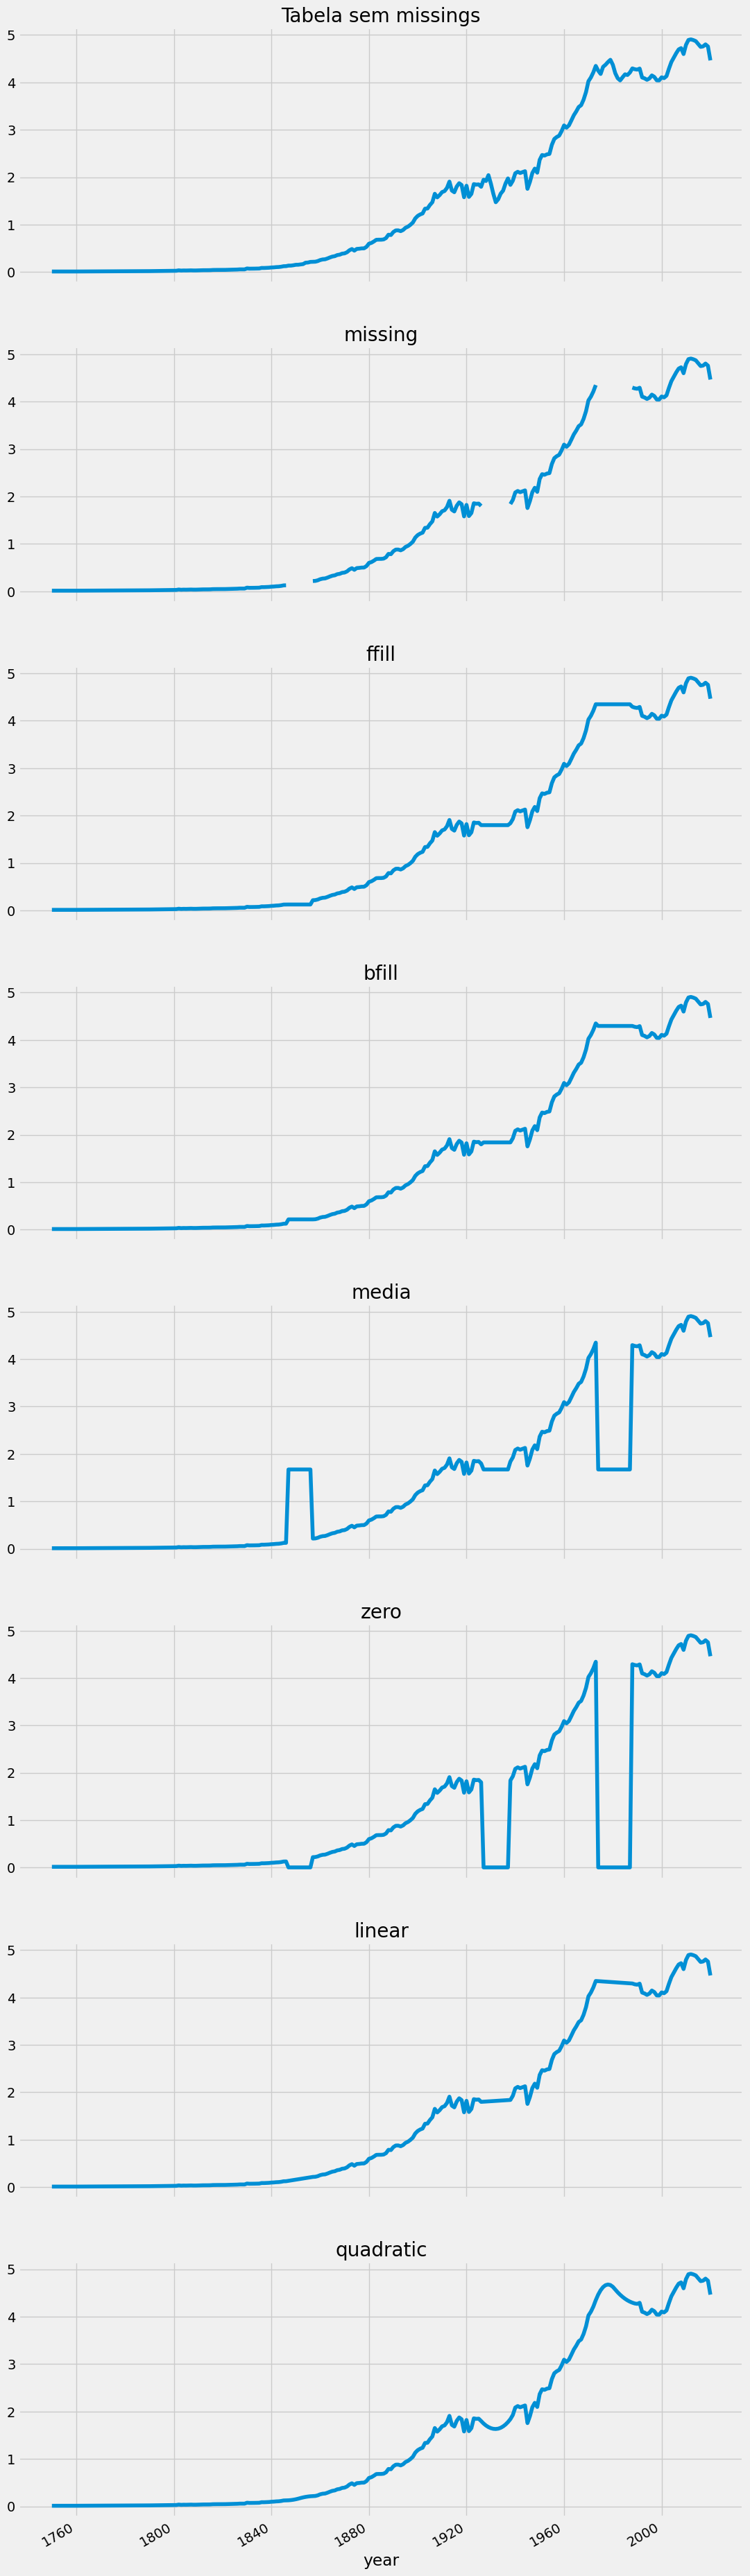

In [6]:
plot_dfs(co2_original, co2_missing, 'co2')

## Imputação Multivariada

In [7]:
clicks_missing.loc['2008-05-10':'2008-05-31']

,price,location,clicks
date,,,
2008-05-10,42.576299,1,4863.0
2008-05-11,43.405890,5,6511.0
2008-05-12,43.258326,2,17426.0
2008-05-13,42.714479,2,4160.0
2008-05-14,43.372786,5,9841.0
2008-05-15,42.517755,2,NaN
2008-05-16,44.011009,2,NaN
2008-05-17,42.530303,2,NaN
2008-05-18,42.565698,5,NaN


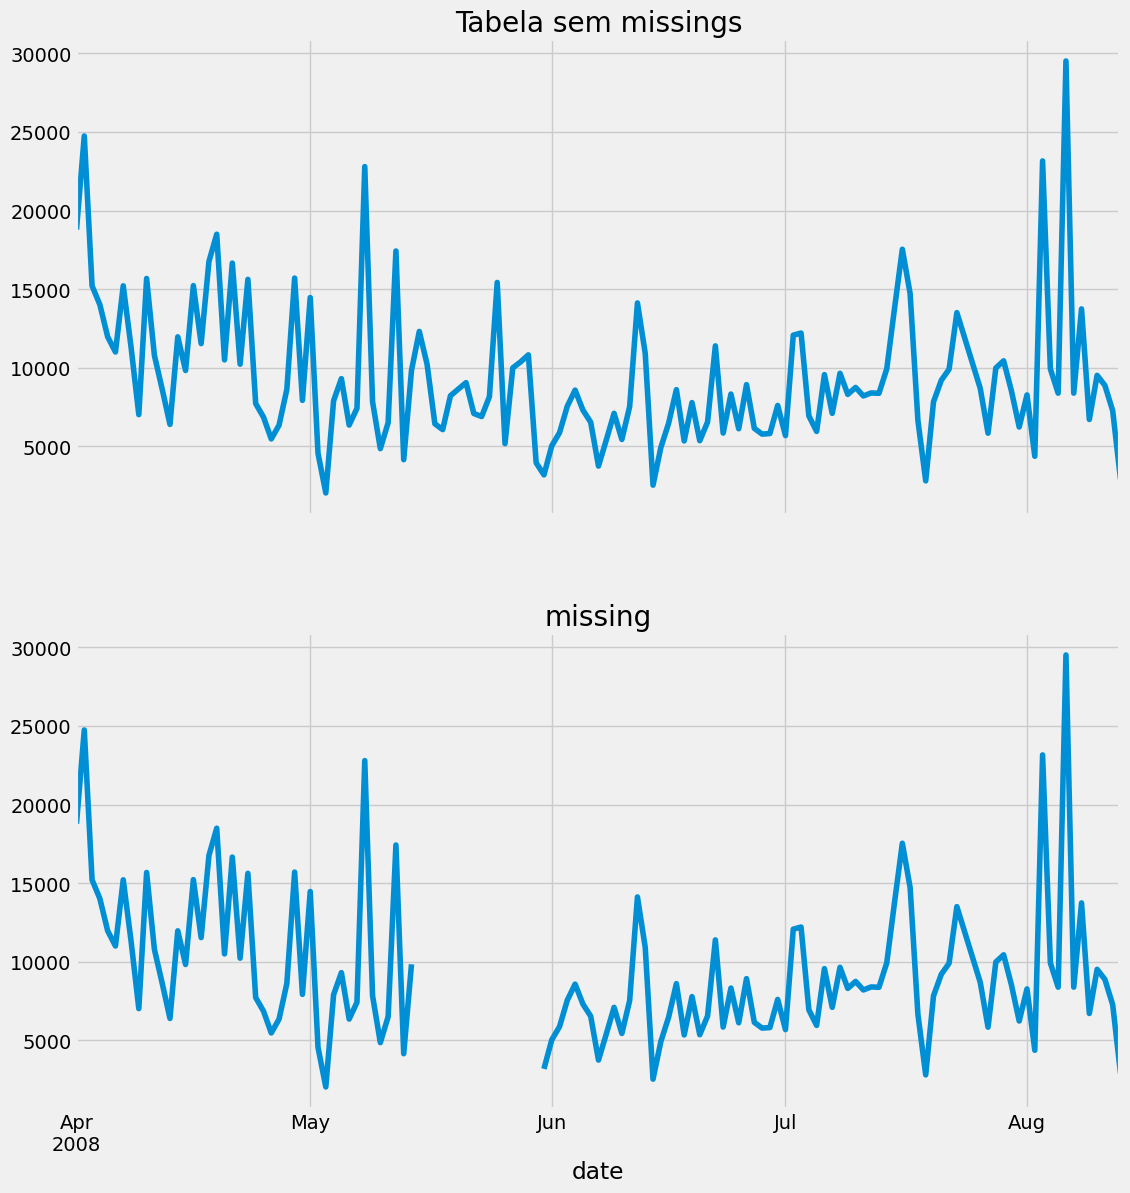

In [8]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [10]:
estimators = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=10)),
    ('bagging', BaggingRegressor(n_estimators=10)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))]

clicks_vals = clicks_missing.iloc[:,0:3].values
for e_name, e in estimators:
    est = IterativeImputer(
                random_state=15,
                estimator=e).fit(clicks_vals)
    clicks_missing[e_name] = est.transform(clicks_vals)[: , 2]
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455849
RMSE for extra_trees: 1508.3144903672612
RMSE for bagging: 1242.2734943702271
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427186
RMSE for knn: 1336.8798392251822


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


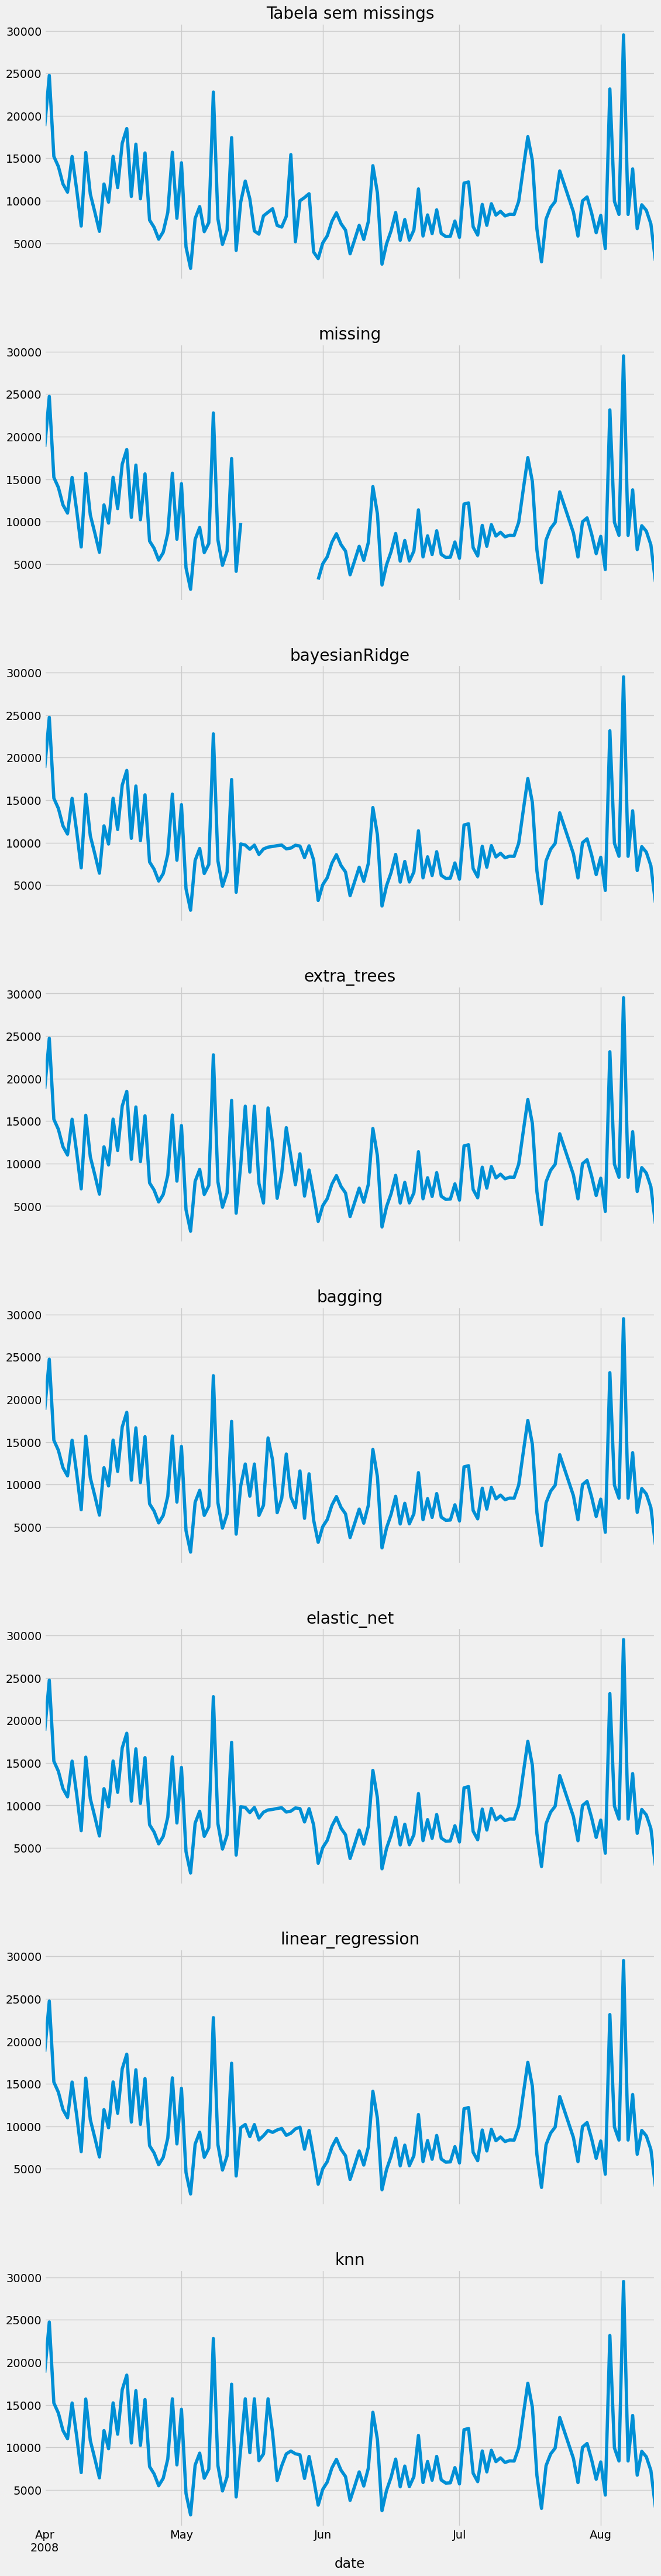

In [11]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

## Holdout

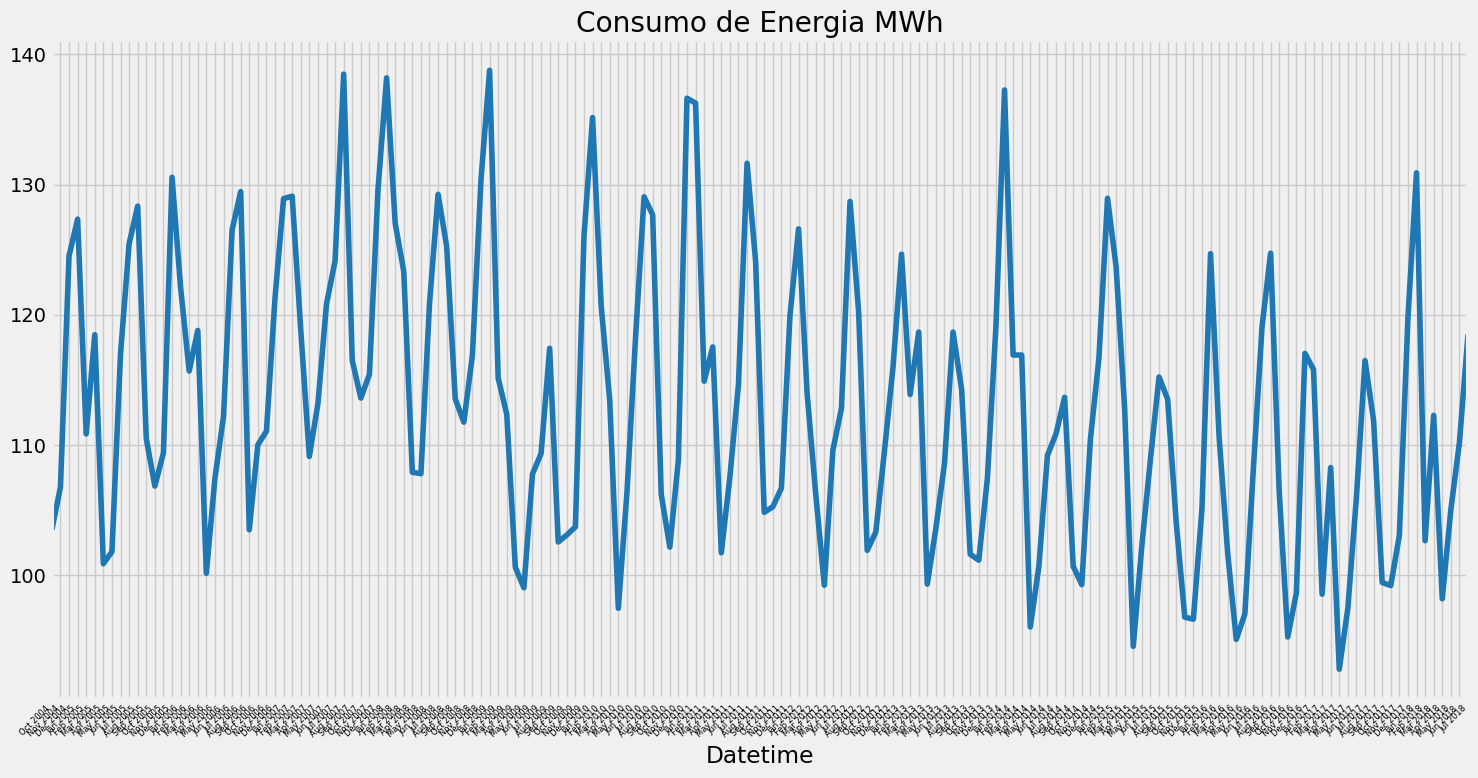

In [21]:
df = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
monthly_data = df.resample('MS').sum()/100000
monthly_data = monthly_data.drop(monthly_data.index[-1])
monthly_data.plot(style='-', figsize=(15, 8), color=color_pal[0], title='Consumo de Energia MWh', legend = False)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b %Y'), rotation=45, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

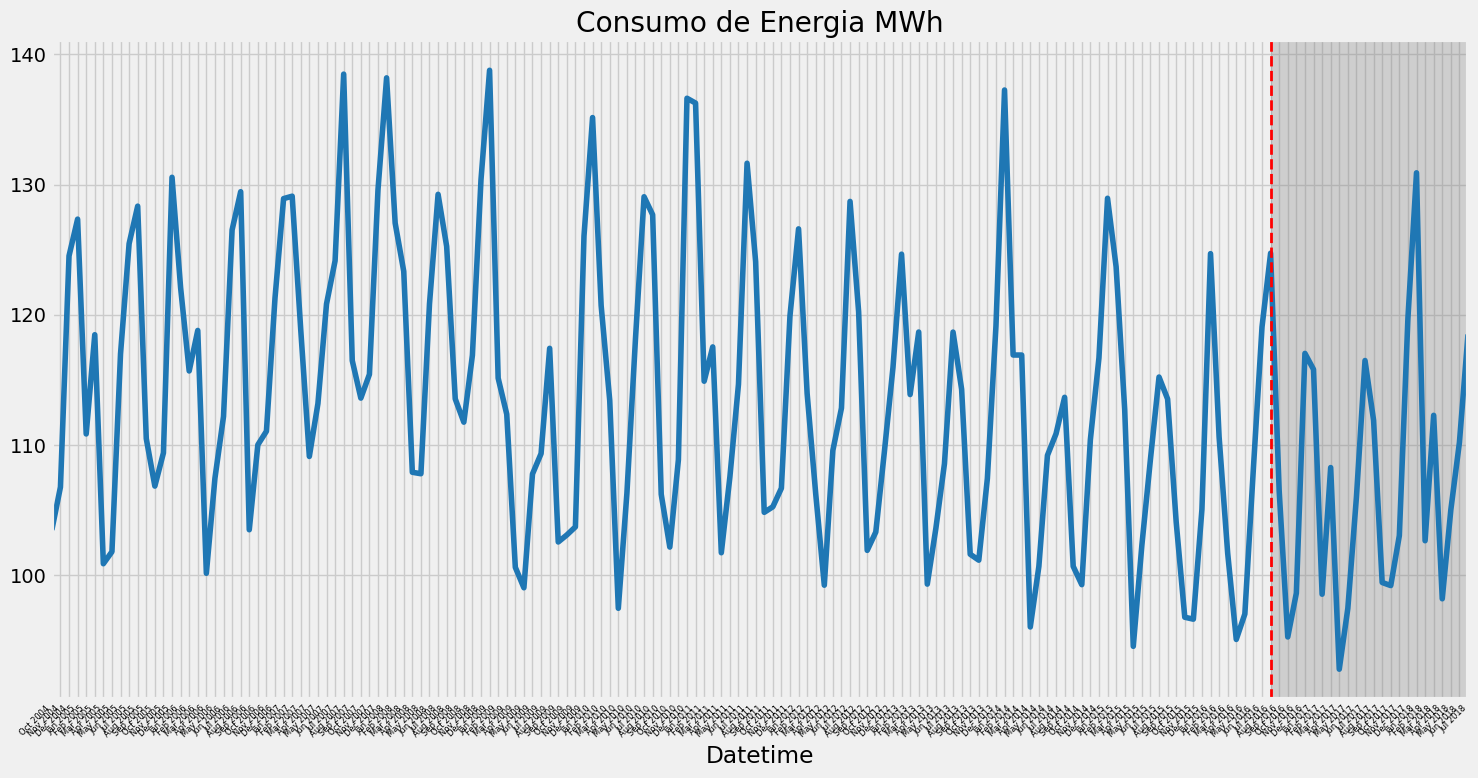

In [24]:
monthly_data.plot(style='-', figsize=(15, 8), color=color_pal[0], title='Consumo de Energia MWh', legend = False)
holdout_start = monthly_data.index[-24]
plt.axvline(holdout_start, color='red', linestyle='--', lw=2)
plt.axvspan(holdout_start, monthly_data.index[-1], color='gray', alpha=0.3)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b %Y'), rotation=45, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

In [32]:
energy_train = monthly_data[:-24]
energy_holdout = monthly_data[-24:]
print(f'Train start = {energy_train.index.min()}')
print(f'Train end = {energy_train.index.max()}')
print(f'HoldOut start = {energy_holdout.index.min()}')
print(f'HoldOut end = {energy_holdout.index.max()}')

Train start = 2004-10-01 00:00:00
Train end = 2016-07-01 00:00:00
HoldOut start = 2016-08-01 00:00:00
HoldOut end = 2018-07-01 00:00:00


In [34]:
len(energy_holdout)*[energy_train.mean()]

[AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64,
 AEP_MW    114.087769
 dtype: float64]